In [64]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import easyocr
import numpy as np
from mss import mss
import keyboard

reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [65]:
def display_image(box):
    plt.figure()
    plt.title(f"Box: {box.class_name} (Confidence: {box.confidence:.2f})")
    plt.imshow(cv2.cvtColor(box.image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [66]:
class Box:
    def __init__(self, id, image, x1, y1, x2, y2, class_name, confidence):
        self.id = id
        self.image = image
        self.x1, self.y1, self.x2, self.y2 = x1, y1, x2, y2
        self.xc, self.yc = (x1 + x2) // 2, (y1 + y2) // 2
        self.class_name = class_name
        self.text = self.ocr()
        self.confidence = confidence

    def ocr(self):
        gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        results = reader.readtext(gray)
        detected_text = ''.join([result[1] for result in results]) 
        return detected_text
    
    def __str__(self):
        return f"Box {self.id}: {self.class_name} ({self.confidence:.2f}) \nCenter: ({self.xc}, {self.yc}) \nText: {self.text}"

Press 'i' to capture the screen and process.
Press 'q' to quit.
Box 0: card (0.96) 
Center: (773, 1006) 
Text: Forest


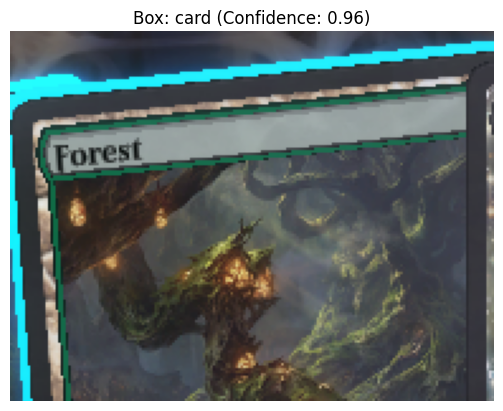



-------------------


Box 0: card (0.96) 
Center: (1302, 1017) 
Text: AncientPietLore


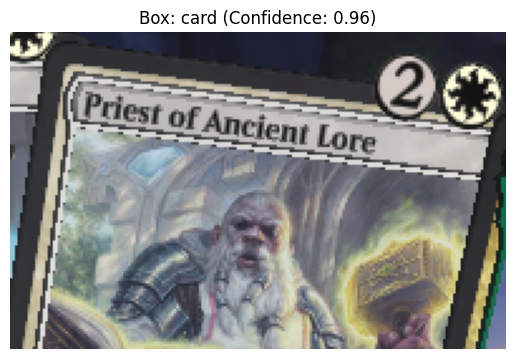



-------------------


Box 0: card (0.96) 
Center: (592, 1015) 
Text: Forest


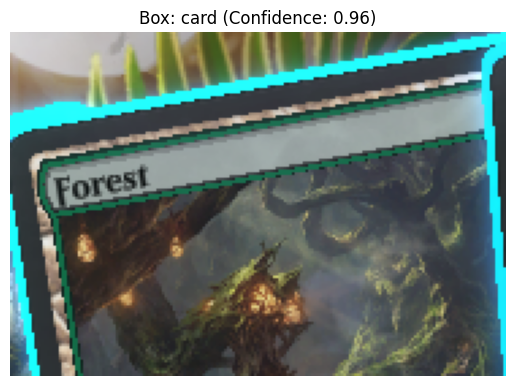



-------------------


Box 0: card (0.96) 
Center: (953, 1002) 
Text: Cleric ClassMennitenext lerdlas =tantqolnIeminenaitFenekannMlerEEcioputa -V/elccurtel


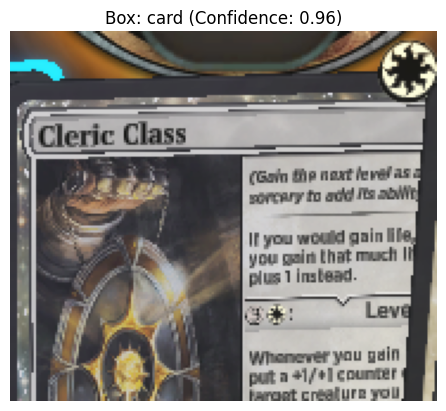



-------------------


Box 0: button (0.95) 
Center: (1775, 950) 
Text: Next


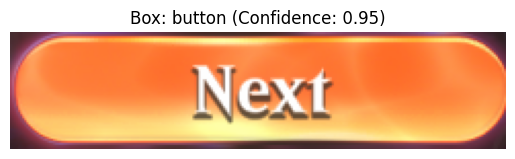



-------------------


Box 0: card (0.94) 
Center: (1126, 1007) 
Text: HallowedPricst


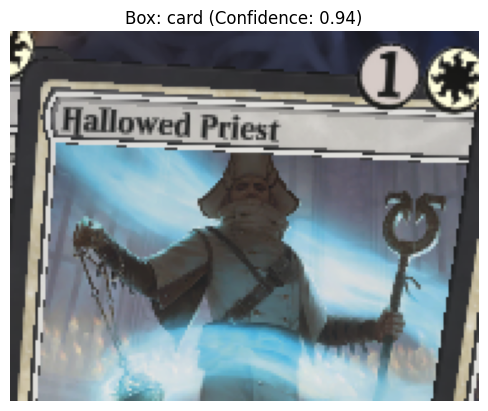



-------------------


Box 0: card (0.93) 
Center: (414, 1032) 
Text: 


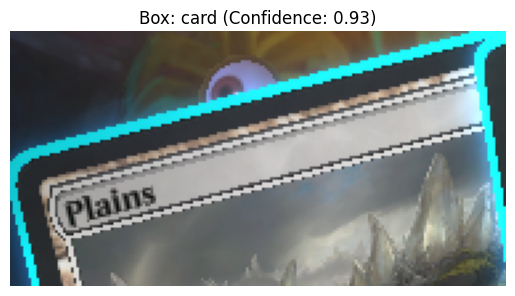



-------------------


Box 0: card (0.90) 
Center: (1484, 1035) 
Text: Trelasan;Moon [Dancer


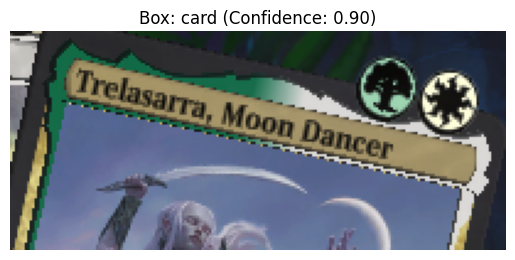



-------------------


Exiting...


In [ ]:
tuned_model = "yolo11s_tuned_50.pt"

def process_frame(model, frame):
    img = cv2.cvtColor(np.array(frame), cv2.COLOR_BGRA2BGR)
    
    # Run inference
    results = model.predict(img, conf=0.5, verbose=False)

    # Extract bounding boxes
    boxes = []
    for i, box in enumerate(results[0].boxes):
        x_min, y_min, x_max, y_max = map(int, box.xyxy[0].tolist())
        class_id = int(box.cls[0])
        class_name = model.names[class_id]
        confidence = float(box.conf[0])

        boxes.append(Box(
            id=0,
            image=img[y_min:y_max, x_min:x_max],
            x1=x_min, 
            x2=x_max,
            y1=y_min,
            y2=y_max, 
            class_name=class_name,
            confidence=confidence
        ))

    return boxes

def app():
    model = YOLO(tuned_model)

    monitor = {"top": 0, "left": 0, "width": 1920, "height": 1080}
    sct = mss()

    print("Press 'i' to capture the screen and process.")
    print("Press 'q' to quit.")

    while True:
        if keyboard.is_pressed("i"):
            screen = sct.grab(monitor)
            boxes = process_frame(model, screen)
            for box in boxes:
                print(box)
                display_image(box)
                print("\n\n-------------------\n\n")

        if keyboard.is_pressed("q"):
            print("Exiting...")
            break

app()
